<a href="https://colab.research.google.com/github/Simurgh818/BMED_6517_emotional_state_classifier/blob/main/EEG_Spectrogram_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve


import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [ ]:
%pylab inline
import math

from matplotlib import cm # to get a matplotlib.colors.ListedColormap
from matplotlib import style
style.use('fivethirtyeight')

from scipy import signal

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
# Importing the preprocessed dataset files
!wget https://drive.google.com/drive/folders/1_9n-kRKkpnCC2wVovOJsIXOyY3BeW1TB?usp=sharing

--2022-12-04 19:50:25--  https://drive.google.com/drive/folders/1_9n-kRKkpnCC2wVovOJsIXOyY3BeW1TB?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.251.31.102, 142.251.31.100, 142.251.31.139, ...
Connecting to drive.google.com (drive.google.com)|142.251.31.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘1_9n-kRKkpnCC2wVovOJsIXOyY3BeW1TB?usp=sharing’

1_9n-kRKkpnCC2wVovO     [ <=>                ] 220.94K  --.-KB/s    in 0.1s    

2022-12-04 19:50:25 (1.57 MB/s) - ‘1_9n-kRKkpnCC2wVovOJsIXOyY3BeW1TB?usp=sharing’ saved [226240]



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p


In [ ]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']


In [ ]:
labels = []
data = []

filename = "/content/drive/MyDrive/Data/s01.dat"
trial = read_eeg_signal_from_file(filename)
labels.append(trial['labels'])
data.append(trial['data'])

In [ ]:
labels = np.array(labels)
print("Labels - previous: ", labels.shape) # trial x label
labels = labels.flatten()
labels = labels.reshape(40, 4)

data = np.array(data)
print("Data - previous: ", data.shape) # trial x channel x data  
data = data.flatten()
data = data.reshape(40, 40, 8064)

Labels - previous:  (1, 40, 4)
Data - previous:  (1, 40, 40, 8064)


In [ ]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data


Labels:  (40, 4)
Data:  (40, 40, 8064)


In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(40, 32, 8064)


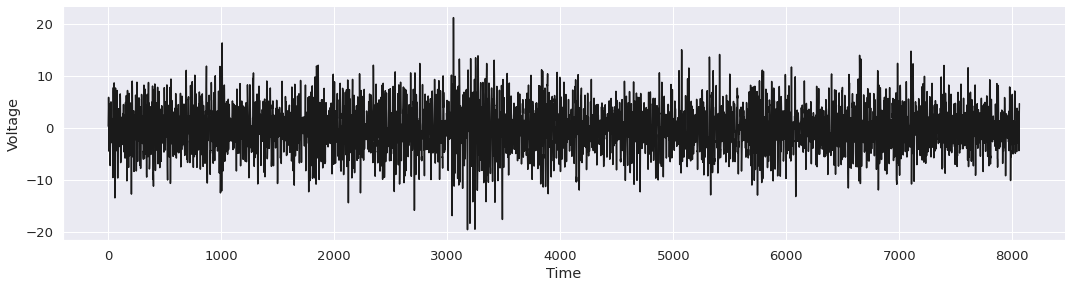

In [ ]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
# time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

In [ ]:
# Fourier transform
eeg = eeg_data[0,31]
FourierCoeff = np.fft.fft(eeg/eeg.size)
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

Nyquist = sf/2
print('Nyquist frequency = %2.4f Hz'%Nyquist)
Nsamples = int( math.floor(eeg.size/2) )
hz = np.linspace(0, Nyquist, num = Nsamples + 1 )
dhz = hz[1]
print('Spectral resolution = %2.4f Hz'%hz[1])

Nyquist frequency = 64.0000 Hz
Spectral resolution = 0.0159 Hz


In [ ]:
# Perform Welch's periodogram
segment = int( 4*sf ) 
myhann = signal.get_window('hann', segment)

# obtain the power (uV^2) spectrum with Hann window and 50% overlap
myparams = dict(fs = sf, nperseg = segment, window = myhann, noverlap = segment/2, 
                scaling = 'spectrum', return_onesided = True)
freq, ps = signal.welch(x = eeg, **myparams)# units uV**2
ps = 2*ps

# obtain the power density/Hz (uV^2) spectrum with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = sf, nperseg = segment, window = myhann, noverlap = segment/2, 
                 scaling = 'density', return_onesided = True)
freq, psd = signal.welch(x = eeg, **myparams2)# units uV**2/Hz
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2500 Hz


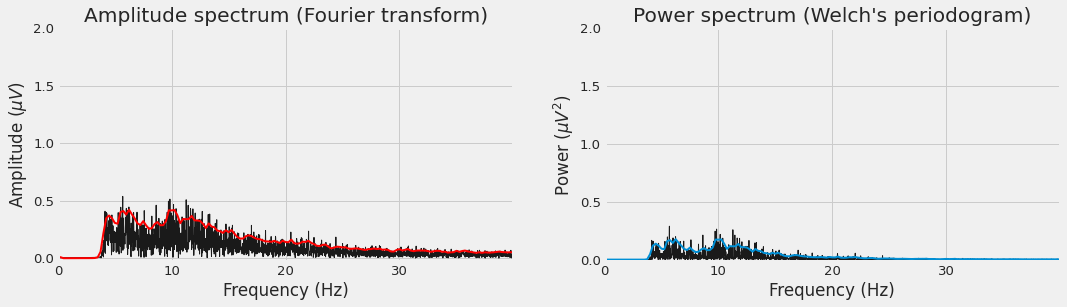

In [ ]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].plot(hz,amp[:len(hz)], lw=1, color='k')#, use_line_collection = True)
ax[0].plot(freq, np.sqrt(ps/10), color='red', lw=2) 
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power spectrum (Welch's periodogram)")
ax[1].plot(hz, np.power(amp[:len(hz)],2), color='k', lw =1)
ax[1].plot(freq, (ps/10), color='C0', lw=2)#, use_line_collection = True)
ax[1].set_ylabel('Power ($\mu V^2$)')

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,40)
    myticks = list(range(0,40,10))
    myax.set_xticks(myticks)
    myax.set_ylim(ymax=2)

In [ ]:
# now we will analyze window lenghts of 500 ms in 25 ms steps. 

WinLength = int(0.5*sf) # 500 points (0.5 sec, 500 ms)
step = int(0.025*sf) # 25 points (or 25 ms)

# we have less resolution here because the signals are smaller
Nsamples = int( np.floor(WinLength/2) )
hz = np.linspace(0,Nyquist, Nsamples + 1)
dfreq = hz[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 2.0000 Hz


In [ ]:
nsteps = int(np.floor ( (eeg.size - WinLength)/step) )
print(eeg.size, nsteps)

8064 2666


In [ ]:
time = np.arange(eeg.size) / sf
print(time.size)

8064


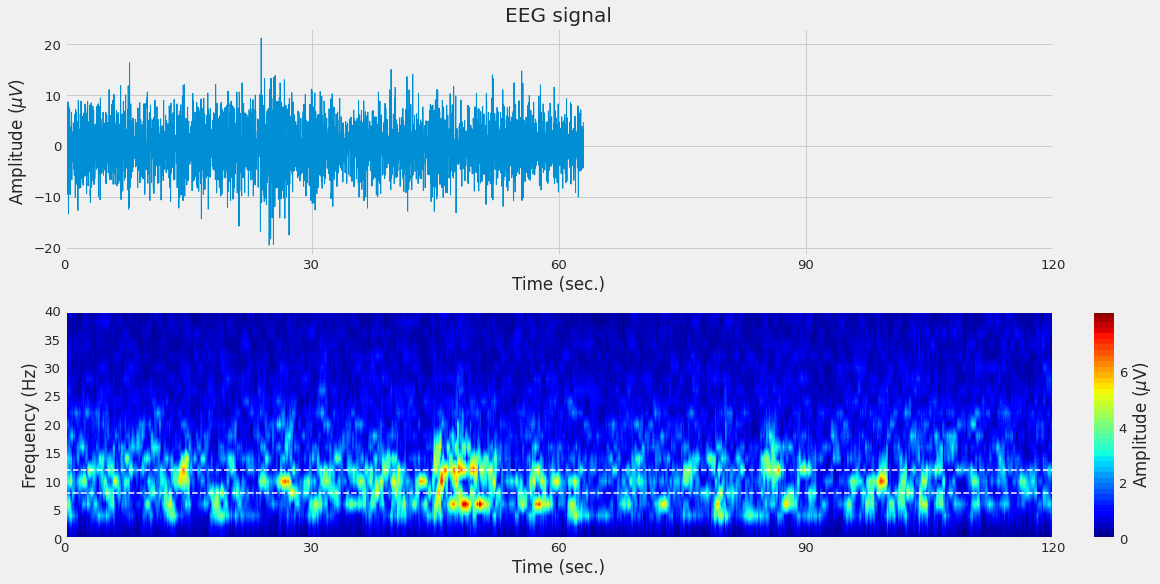

In [ ]:
myamp = list()
for i in range(nsteps):
    
    # signal duration 500 ms (512 data points)
    data = eeg[i*step:i*step+WinLength]
    
    FourierCoeff = np.fft.fft(data)/WinLength
    DC = [np.abs(FourierCoeff[0])] # DC component
    amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))
    
    amp = amp[:int(45/dfreq)]
    myamp.append( amp )

power = np.power(myamp, 2)
#logpower = 10*np.log10(power)
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)
#fig.suptitle('Time-frequency power via short-time FFT')

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 120/nsteps # 120 seconds in number of steps
X = np.arange(nsteps)*dt
Y = hz[:int(45/dfreq)]
Z = np.array(myamp).T
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(myamp)))            # colorbar min value
m4=int(np.ceil(np.max(myamp)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    myax.set_xlim(0, 120)
    myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')

In [ ]:
signal.spectrogram?

In [ ]:
myparams = dict(nperseg = WinLength, noverlap = WinLength-step, return_onesided=True, mode='magnitude')
f, nseg, Sxx = signal.spectrogram(x = eeg, fs = sf, **myparams)

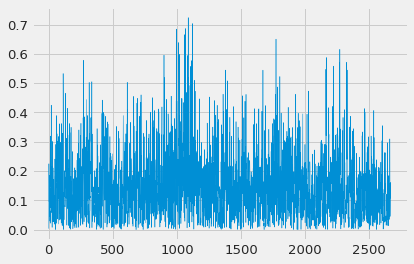

In [ ]:
plt.plot(Sxx[0], lw =0.5)

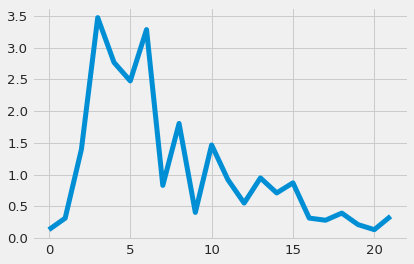

In [ ]:
plt.plot(myamp[0], lw=5)

In [ ]:
f[1]

2.0

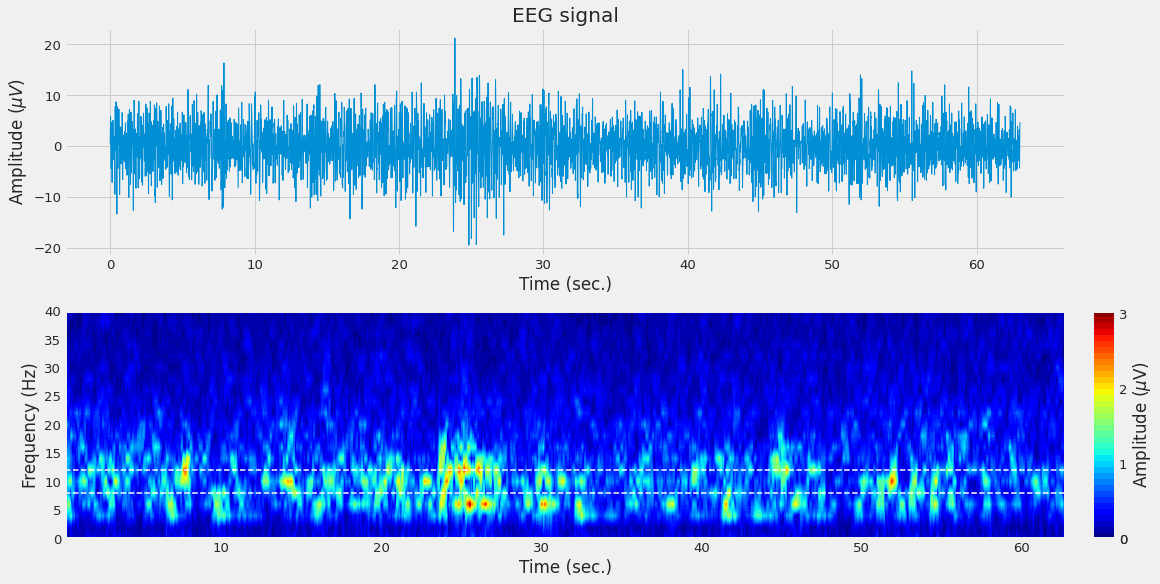

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 120/nsteps # 120 seconds in number of steps
X = nseg
Y = f
Z = Sxx
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(Sxx)))            # colorbar min value
m4=int(np.ceil(np.max(Sxx)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    #myax.set_xlim(0, 120)
    #myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')